In [1]:
import random 
import math

import numba
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from madigan.environments import make_env
from madigan.environments.cpp import Broker, Synth, Env as EnvC
from madigan.environments.cpp import Assets, RiskInfo, EnvInfoMulti, EnvInfoSingle

from madigan.fleet import make_agent

from madigan.utils.preprocessor import make_preprocessor as _make_preprocessor
from madigan.utils import make_config, State
from madigan.utils import ReplayBuffer, SARSD, DiscreteActionSpace
from madigan.utils import list_2_dict, reduce_train_metrics


from madigan.run.test import test
from madigan.utils.plotting import plot_test_metrics

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
config = make_config(
        experiment_id="SineQ",
        basepath="/media/hemu/Data/Markets/farm",
        overwrite_exp=False,
        test_steps=1_000,
        nsteps=1_000_000,
        transaction_cost_rel=0.01,
    
        assets=["OU1"],
        data_source_type="SineAdder",
        generator_params={
            'freq':[2.2, 4.1, 1., 3.],
            'mu':[.6, 0.3, 2., 4.2],
            'amp':[.5, 0.2, 0.4, 1.2],
            'phase':[0., 1., 4., 0.],
            'dX':0.01,
            "noise": 0.0},
#         data_source_type="OU",
#         generator_params=dict(
#             theta=[1.],
#             phi = [1.],
#             noise_var = [1.],
            
#         ),

        preprocessor_type="WindowedStacker",
        window_length=64,
    
        agent_type = "DQN",
        discrete_actions=True,
        discrete_action_atoms=3,
        double_dqn=True,
        nstep_return = 3,
        target_update_freq=12000,
        rb_size=100_000,
        min_rb_size=50_000,
        batch_size=32,
        discount = 0.999,
        lot_unit_value=100_000,
    
    
        model_class="ConvModel",
        lr=1e-3,

    )
config

{'basepath': '/media/hemu/Data/Markets/farm',
 'experiment_id': 'SineQ',
 'parent_id': '',
 'overwrite_exp': False,
 'transaction_cost_abs': 0.0,
 'transaction_cost_rel': 0.01,
 'slippage_abs': 0.0,
 'slippage_rel': 0.0,
 'env_type': 'Synth',
 'data_source_type': 'SineAdder',
 'init_cash': 1000000,
 'required_margin': 1.0,
 'maintenance_margin': 0.25,
 'generator_params': {'freq': [2.2, 4.1, 1.0, 3.0],
  'mu': [0.6, 0.3, 2.0, 4.2],
  'amp': [0.5, 0.2, 0.4, 1.2],
  'phase': [0.0, 1.0, 4.0, 0.0],
  'dX': 0.01,
  'noise': 0.0},
 'assets': ['OU1'],
 'lot_unit_value': 100000,
 'n_assets': 1,
 'discrete_actions': True,
 'discrete_action_atoms': 3,
 'preprocessor_type': 'WindowedStacker',
 'preprocessor_config': {'window_length': 64},
 'agent_type': 'DQN',
 'agent_config': {'type': 'DQN',
  'basepath': '/media/hemu/Data/Markets/farm',
  'discrete_action_atoms': 3,
  'model_config': {'model_class': 'ConvModel',
   'd_model': 256,
   'n_layers': 4,
   'n_feats': 1,
   'action_atoms': 3,
   'n_a

## Env

In [3]:
@numba.njit
def ternarize_array(arr):
    out = np.empty_like(arr)
    out[arr<0.] = -1.
    out[arr==0.] = 0.
    out[arr>0.] = 1.
    return out
# test
ara = np.random.randn(10)
out = ternarize_array(ara)
ara, out

(array([-0.70201726, -0.57958206,  1.19119282,  1.22320072,  0.38948872,
         1.55826229,  0.7655399 , -0.86206551, -0.12186737,  1.88394256]),
 array([-1., -1.,  1.,  1.,  1.,  1.,  1., -1., -1.,  1.]))

In [4]:
# @numba.vectorize([numba.int32(numba.int32),
#                   numba.int64(numba.int64),
#                   numba.float32(numba.float32),
#                   numba.float64(numba.float64)])

@numba.vectorize([numba.float32(numba.float32),
                  numba.float64(numba.float64)])
def ternarize_array(val):
    if val < 0:
        out = -1.
    elif val > 0.:
        out = 1.
    else:
        out = 0.
    return out
# test
ara = np.random.randn(10, 1)
out = ternarize_array(ara)
ara, out

(array([[-1.32922778],
        [-0.3712605 ],
        [ 0.8276056 ],
        [ 1.49226636],
        [ 1.33125458],
        [ 0.48690322],
        [ 2.00076689],
        [-0.32110771],
        [ 1.32094653],
        [-2.17859303]]),
 array([[-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.]]))

In [5]:
from dataclasses import dataclass

@dataclass
class BrokerResponse:
    event: str
    timestamp: int
    transPrice: float
    transUnits: float
    transCost: float
    riskInfo: object
    marginCall: bool

@dataclass
class EnvInfo:
    brokerResponse: BrokerResponse
    exiting: bool
        

In [6]:
class EnvTernary(EnvC):
    def step(self, actions: np.ndarray = None):
        """
        If actions is None, no transaction is attempted and dataSource is iterated to
        get new prices
        If actions is passed, a transaction/s is attempted. Can only Reverse Positions, not add to 
        or close.
        Hence EnvBinary.
        """

        if actions is None: # no transaction
            prevEq = self.portfolio.equity
            newPrices = self.dataSource.getData()
            newEq = self.portfolio.equity
            reward = (newEq-prevEq) / prevEq
            risk = self.portfolio.checkRisk()
            done = False if risk == RiskInfo.green else True

            return (State(newPrices, np.array(self.ledgerNormed, copy=True),
                          self.dataSource.currentTime),
                    reward, done, EnvInfo(BrokerResponse("", 0, 0., 0., 0., 
                                                             risk, done), False))
        else:
            if not isinstance(actions, np.ndarray):
                raise TypeError("action must be an np array")

            prevEq = self.portfolio.equity
            newPrices = self.dataSource.getData()
            newEq = self.portfolio.equity
            reward = newEq / prevEq 
            reward = math.log(max(reward, 0.3))

            ledger_ternary = self.ledgerTernary
            actions_ternary = actions - 1
#             actions_ternary[ledger_ternary == actions_ternary] = 0.
            units = (0.2*self.availableMargin) / self.currentPrices
            transactions = actions_ternary * units

#             exiting = False
            assets = np.where(transactions!=0.)[0]
            for i, asset in enumerate(assets): # implicit if len(assets)
                reward -= self.transaction_cost_rel
#                 if self.ledger[i] != 0:
#                     exiting = True
#                     self.broker.close(int(asset))
                    
            broker_response_multi = self.broker.handleTransaction(transactions)
            
            done = False
            if broker_response_multi.marginCall:
                done=True
            for _risk in broker_response_multi.riskInfo:
                if _risk != RiskInfo.green:
                    done = True
#             if exiting:
#                 done = True
            if self.equity < 0.1 * self.portfolio.initCash:
                done = True
                print('equity: ', self.equity)

            return (State(newPrices, np.array(self.ledgerNormed, copy=True),
                          self.dataSource.currentTime),
                    reward, done, EnvInfo(broker_response_multi, 0.))

    @property
    def ledgerTernary(self):
        ara = np.array(self.ledger, copy=True)
        return ternarize_array(ara)
    

In [7]:
# def make_env(config):
#     assets = Assets(config.assets)
#     env = EnvTernary(config.data_source_type, assets, config.init_cash, config)
#     env.lot_unit = config.lot_unit_value
#     env.action_atoms = config.discrete_action_atoms
#     env.transaction_cost_rel = config.transaction_cost_rel
# #     env.setTransactionCost
#     return env

In [8]:
env = make_env(config)
srdi = env.step(np.array([10000]))
print('reward:', srdi[1])
print('reward:', env.step()[1])
env.step(np.array([0]))
env.reset()
print(env.currentPrices, env.cash, env.equity, env.ledger, env.availableMargin)

reward: 0.0
reward: 0.003362993925419609
[7.21755705] 1000000.0 1000000.0 [0.] 1000000.0


In [9]:
srdi[3].brokerResponse.transactionCost

array([757.38695427])

In [10]:
from collections import deque
import sklearn.preprocessing

class Preprocessor:
    def __init__(self, window_len):
        self.k = window_len
        self.min_tf = self.k
        self.price_buffer = deque(maxlen=self.k)
        self.portfolio_buffer = deque(maxlen=self.k)
        self.time_buffer = deque(maxlen=self.k)
        self.feature_output_size = 12

    def __len__(self):
        return len(self.price_buffer)

    def stream_srdi(self, srdi):
        self.price_buffer.append(srdi[0].price)
        self.portfolio_buffer.append(srdi[0].portfolio)
        self.time_buffer.append(srdi[0].timestamp)

    def stream_state(self, state):
        self.price_buffer.append(np.array(state.price, copy=True))
        self.portfolio_buffer.append(np.array(state.portfolio, copy=True))
        self.time_buffer.append(np.array(state.timestamp, copy=True))

    def stream(self, data):
        if isinstance(data, tuple): # assume srdi
            self.stream_srdi(data)
        elif isinstance(data, (StateA, State)):
            self.stream_state(data)

    def current_data(self):
        prices = np.array(self.price_buffer, copy=True)
        prices = sklearn.preprocessing.minmax_scale(prices)
        features = np.empty(self.feature_output_size)
        for i, window in enumerate([3, 5, 7, 11]):
            features[i] = np.mean(prices[-window:])
            features[i+4] = np.var(prices[-window:])
        features[8] = prices.min()
        features[9] = prices.max()
        features[10] = prices[0]
        features[11] = prices[-1]
        return State(features.reshape(-1, 1) ,
                     self.portfolio_buffer[-1],
                     self.time_buffer[-1])

    def initialize_history(self, env):
        while len(self) < self.k:
            _state, reward, done, info = env.step()
            self.stream_state(_state)


In [11]:
def make_preprocessor(config):
    if config.preprocessor_type == "Custom":
        return Preprocessor(config.preprocessor_config.window_length)
    return _make_preprocessor(config)

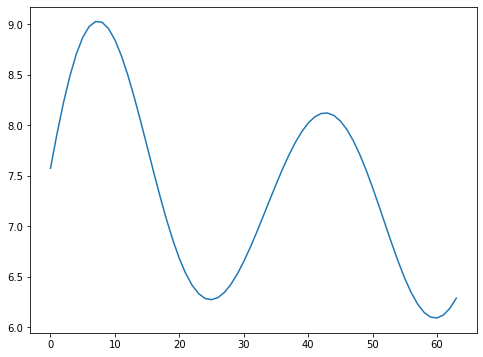

In [12]:
from IPython.core.pylabtools import figsize
figsize(8, 6)

preprocessor = make_preprocessor(config)
env.currentPrices
preprocessor.initialize_history(env)
plt.plot(preprocessor.current_data().price)
env.reset()

## Agent

In [13]:
from madigan.fleet.conv_model import calc_conv_out_shape

class DuelingHead(nn.Module):
    """
    Replace normal output layer in DQN with this for Dueling Network Architectures
    See: https://arxiv.org/pdf/1511.06581.pdf
    """

    def __init__(self, d_in, d_out):
        super().__init__()
        self.value_net = nn.Linear(d_in, 1)
        self.adv_net = nn.Linear(d_in, d_out)
    def forward(self, x):
        value = self.value_net(x)
        adv = self.adv_net(x)
        qvals = value + adv - adv.mean(-1, keepdim=True)
        return qvals
    
class ConvModel(nn.Module):
    def __init__(self, config, feature_input_size):
        super().__init__()
        nassets = len(config.assets)
        d_model = config.agent_config.model_config.d_model
        nactions = config.discrete_action_atoms
        self.conv1 = nn.Conv1d(1, 32, 5)
        self.conv2 = nn.Conv1d(32, 32, 5)
        out_shape = calc_conv_out_shape(feature_input_size, [self.conv1, self.conv2])
        self.fc1 = nn.Linear(nassets+out_shape[0]*32, d_model)
        self.output_head = nn.Linear(d_model, nactions)
        self.act = nn.GELU()     
        
    def forward(self, state):
        price = state.price.transpose(-1, -2)
        portfolio = state.portfolio
        price_emb = self.act(self.conv1(price))
        price_emb = self.act(self.conv2(price_emb)).view(price.shape[0], -1)

        full_emb = torch.cat([price_emb, portfolio], dim=-1)
        out = self.act(self.fc1(full_emb))

        logits = self.output_head(out)
        return logits
        

In [51]:
import warnings
import torch.nn.functional as F
from torch.distributions import Categorical
from madigan.utils import DiscreteRangeSpace, DiscreteActionSpace

# class EpisodeBuffer:
#     def __init__(self, rollout_len=5000):
#         self._buffer = []
#         self.rollout_len = rollout_len
        
#     def add(self, sarsd):
#         if len(self._buffer) < self.rollout_len:
#             self._buffer.append(sarsd)
#         else:
#             warnings.warning("Max length of experience buffer exceeded")
            
#     def get_episode(self):
#         return self._buffer

class AgentCNN:
    def __init__(self, config, feature_input_size, env, device=None):
        self.device = device or ('cuda' if torch.cuda.is_available() else 'cpu')
        self._env = env
        
        self.action_atoms = config.discrete_action_atoms

        self.lot_unit_value = config.lot_unit_value
        actions = [self.lot_unit_value*action - self.action_atoms//2 for action in range(self.action_atoms)]
        probs = [1/len(actions) for i in actions]
        self._action_space = DiscreteRangeSpace((0, 2), len(config.assets))

        self.actor = ConvModel(config, feature_input_size).to(device).float()
        self.critic_b = ConvModel(config, feature_input_size).to(device).float()
        self.critic_t = ConvModel(config, feature_input_size).to(device).float()
        
        self.dueling = config.agent_config.model_config.dueling
        self.double_dqn = config.agent_config.double_dqn
        self.discount = config.agent_config.discount
        
        self.opt_critic = torch.optim.Adam(self.critic_b.parameters(),
                                           lr=config.agent_config.optim_config.lr_critic)
        self.opt_actor = torch.optim.Adam(self.actor.parameters(), 
                                           lr=config.agent_config.optim_config.lr_actor)
        self.tau_soft_update = config.agent_config.tau_soft_update
        
        self.config = config
        
    @property
    def env(self):
        return self._env
    
    @property
    def action_space(self):
        return self._action_space
    
    def prep_state(self, state, batch=False):
        if not batch:
            price = torch.as_tensor(state.price[None, ...], dtype=torch.float32).to(self.device)
            port = torch.as_tensor(state.portfolio[None, -1], dtype=torch.float32).to(self.device)
        else:
            price = torch.as_tensor(state.price, dtype=torch.float32).to(self.device)
            port = torch.as_tensor(state.portfolio[:, -1], dtype=torch.float32).to(self.device)
#         timestamp = torch.as_tensor(state.timestamp)
        return State(price, port, state.timestamp)
    
    def get_qvals(self, state, target=False):
        state = self.prep_state(state)
        if target:
            qvals = self.critic_t(state)
        else:
            qvals = self.critic_b(state)
        return qvals
    
    def get_policy(self, state):
        state = self.prep_state(state)
        logits = self.actor(state)
        return Categorical(logits=logits)
    
    def action_to_transaction(self, actions):
        units = 0.1 * self.env.availableMargin / self.env.currentPrices
        actions_ternary = (actions - (self.action_atoms // 2)).cpu().numpy()
        return units * actions_ternary
        
    @torch.no_grad()
    def __call__(self, state):
        policy = self.get_policy(state)
        actions = policy.sample()
        return self.action_to_transaction(actions)
        
    def prep_sarsd(self, sarsd):
        state = self.prep_state(sarsd.state, batch=True)
#         action = np.rint(sarsd.action // self.lot_unit_value) + self.action_atoms//2
        action = ternarize_array(sarsd.action) + self.action_atoms // 2
        action = torch.as_tensor(action, dtype=torch.long, device=self.device)[..., 0]
        reward = torch.as_tensor(sarsd.reward, dtype=torch.float32, device=self.device)
        next_state = self.prep_state(sarsd.next_state, batch=True)
        done = torch.as_tensor(sarsd.done, dtype=torch.bool, device=self.device)
        return state, action, reward, next_state, done
    
    def loss_fn(self, Qt, Gt):
        return F.smooth_l1_loss(Qt, Gt)
    
    
    def train_step(self, sarsd_critic, sarsd_actor):
        critic_metrics = self.train_step_critic(sarsd_critic)
        actor_metrics = self.train_step_actor(sarsd_actor)
        return critic_metrics, actor_metrics
    
    def train_step_critic(self, sarsd):
        state, action, reward, next_state, done = self.prep_sarsd(sarsd)
        self.opt_critic.zero_grad()
        with torch.no_grad():
            next_policy = Categorical(logits=self.actor(next_state))    
            next_actions = next_policy.sample()
            one_hot = F.one_hot(next_actions, self.action_atoms).to(self.device)
            greedy_qvals_next = (self.critic_t(next_state)*one_hot).sum(-1)
            Gt = reward + (~done*self.discount * greedy_qvals_next)

        action_mask = F.one_hot(action, self.action_atoms).to(self.device)
        qvals = self.critic_b(state)
        Qt = (qvals*action_mask).sum(-1)
        
        loss = self.loss_fn(Qt, Gt)
        loss.backward()
        self.opt_critic.step()
        
        td_error = (Gt-Qt).abs().mean().detach().item()
        
        self.update_target()
        
        return {'loss': loss.detach().item(), 'td_error': td_error, 'Qt': Qt.detach(), 'Gt': Gt.detach()}
    
    def train_step_actor(self, sarsd_actor):
        state, action, reward, next_state, done = self.prep_sarsd(sarsd_actor)
        logits = self.actor(state)
        logp = Categorical(logits=logits).log_prob(action)
        
        action_mask = F.one_hot(action, self.action_atoms).to(action.device)
        qvals = self.critic_t(state)
        Gt = (qvals*action_mask).sum(-1)
        assert Gt.shape == logp.shape
#         print(Gt.shape, logp.shape)
#         print((Gt * logp).shape)
        loss = (-logp * Gt).mean()
        self.opt_actor.zero_grad()
        loss.backward()
        self.opt_actor.step()
        return {'loss': loss.detach().item()}
    
    def update_target(self):
        """
        Soft Update 
        """
        for behaviour, target in zip(self.critic_b.parameters(), self.critic_t.parameters()):
            target.data.copy_(self.tau_soft_update * behaviour.data + \
                              (1.-self.tau_soft_update)*target.data)        

In [52]:
agent = AgentCNN(config, preprocessor.feature_output_size, env, device=device)

x = preprocessor.current_data()
# x = agent.prep_state(x)
qvals = agent.get_qvals(x)
policy = agent.get_policy(x)
action = policy.sample()
transaction = agent.action_to_transaction(action)
print(qvals, action, transaction)

tensor([[ 0.0470, -0.0649, -0.0060]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([0], device='cuda:0') [-4153.13647216]


## Trainer


In [58]:
def trainer(agent, env, preprocessor, config):
    rb = ReplayBuffer(config.rb_size)
    episode_length = config.episode_length
    
    nstep_buffer = []
    nstep=config.nstep_return
    min_rb_size = config.min_rb_size
    target_update_freq = config.target_update_freq
    
    eps = 1.
    eps_decay = config.expl_eps_decay
    eps_min = config.expl_eps_min
    env.reset()
    preprocessor.initialize_history(env)
    state = preprocessor.current_data()
    i = 0
    running_reward = 0.
    running_cost = 0.
    while True:
        critic_metrics=None
        actor_metrics=None
        
        if random.random() < eps:
            units = 0.1 * env.availableMargin / env.currentPrices
            actions = np.random.choice([-1., 0., 1.], len(units))
            actions *= units
        else:
            actions = agent(state)
        eps = max(eps_min, eps*eps_decay)
        
#         Prevent double positon
#         for i, action in enumerate(actions):
#             if np.sign(action) == np.sign(env.ledger):
#                 actions[i] = 0.
                
        _next_state, reward, done, info = env.step(actions)
        for cost in info.brokerResponse.transactionCost:
            running_cost += cost
#         reward = max(-1., min(reward, 1.))
        preprocessor.stream_state(_next_state)
        next_state = preprocessor.current_data()
        if done:
            reward = -1.
        running_reward += reward
        sarsd = SARSD(state, actions, reward, next_state, done)
        rb.add(sarsd)
#         nstep_buffer.append(sarsd)
#         if len(nstep_buffer) == nstep:
#             _reward = sum([dat.reward for dat in nstep_buffer])
#             nstep_sarsd = nstep_buffer.pop(0)
#             nstep_sarsd.reward = _reward
#             rb.add(nstep_sarsd)
#             running_reward += _reward
        
        if done:
            env.reset()
            preprocessor.initialize_history(env)
            state = preprocessor.current_data()
            print('running_reward: ', running_reward, 'running_cost: ', running_cost)

            running_reward = 0.
            running_cost = 0.
        else:
            state = next_state
        if len(rb) >= min_rb_size:
            sarsd_critic = rb.sample(config.batch_size)
            critic_metrics = agent.train_step_critic(sarsd_critic)
            critic_metrics['eps'] = eps
            critic_metrics['running_reward'] = running_reward

            if i % episode_length == 0:
#                 try:
                sarsd_actor = rb.get_latest(episode_length)
#                 except:
#                     import ipdb; ipdb.set_trace()
                actor_metrics = agent.train_step_actor(sarsd_actor)
            
        yield {'critic': critic_metrics, 'actor': actor_metrics}
        i += 1

In [61]:
config = make_config(
        experiment_id="SineQ",
        basepath="/media/hemu/Data/Markets/farm",
        overwrite_exp=False,
        transaction_cost_rel=0.02,
    
    
        test_steps=1_000,
        nsteps=1_000_000,
    
        assets=["sine1"],
#         data_source_type="Triangle",
#         generator_params={
#         'freq':[2.],
#         'mu':[0.6],
#         'amp':[.5],
#         'phase':[0.],
#         'dX':0.1,
#         "noise": 0.0},
        data_source_type="SineAdder",
        generator_params={
            'freq':[2.2, 4.1, 1., 3.],
            'mu':[.6, 0.3, 2., 4.2],
            'amp':[.5, 0.2, 0.4, 1.2],
            'phase':[0., 1., 4., 0.],
            'dX':0.01,
            "noise": 0.0},
#         data_source_type="OU",
#         generator_params=dict(
#             theta=[.05],
#             phi = [1.],
#             noise_var = [1.]
#         ),
        preprocessor_type="WindowedStacker",
        window_length=64,
    
        agent_type = "DQN",
        discrete_actions=True,
        discrete_action_atoms=3,
        double_dqn=True,
        dueling=True,
        iqn=True,
        nTau1=32,
        nTau2=8,
        k_huber=1,
        nstep_return = 5,
        tau_soft_update=1e-4,
        rb_size=100_000,
        min_rb_size=50_000,
        batch_size=34,
        discount = 0.999,
        lot_unit_value=10_000,
    
        expl_eps_decay=0.999999,
    
        model_class="ConvModel",
        d_model = 256,
        lr=1e-3,

    )
config

{'basepath': '/media/hemu/Data/Markets/farm',
 'experiment_id': 'SineQ',
 'parent_id': '',
 'overwrite_exp': False,
 'transaction_cost_abs': 0.0,
 'transaction_cost_rel': 0.02,
 'slippage_abs': 0.0,
 'slippage_rel': 0.0,
 'env_type': 'Synth',
 'data_source_type': 'SineAdder',
 'init_cash': 1000000,
 'required_margin': 1.0,
 'maintenance_margin': 0.25,
 'generator_params': {'freq': [2.2, 4.1, 1.0, 3.0],
  'mu': [0.6, 0.3, 2.0, 4.2],
  'amp': [0.5, 0.2, 0.4, 1.2],
  'phase': [0.0, 1.0, 4.0, 0.0],
  'dX': 0.01,
  'noise': 0.0},
 'assets': ['sine1'],
 'lot_unit_value': 10000,
 'n_assets': 1,
 'discrete_actions': True,
 'discrete_action_atoms': 3,
 'preprocessor_type': 'WindowedStacker',
 'preprocessor_config': {'window_length': 64},
 'agent_type': 'DQN',
 'agent_config': {'type': 'DQN',
  'basepath': '/media/hemu/Data/Markets/farm',
  'discrete_action_atoms': 3,
  'model_config': {'model_class': 'ConvModel',
   'd_model': 256,
   'n_layers': 4,
   'n_feats': 1,
   'action_atoms': 3,
   'n_

# Training

In [62]:
env = make_env(config)

# agent = make_agent(config)

preprocessor = make_preprocessor(config)
preprocessor.initialize_history(env)

agent = AgentCNN(config, preprocessor.feature_output_size, env, device=device)
# agent = AgentCNN_IQN(config, preprocessor.feature_output_size, env, device=device)

In [63]:
train_loop = iter(trainer(agent, env, preprocessor, config))
# INITIALIZE REPLAY BUFFER
print("Initializing replay buffer with min # of experiences")
for i in tqdm(range(config.min_rb_size)):
    metrics = next(train_loop)
    
train_metrics=[]

Initializing replay buffer with min # of experiences


running_reward:  -1.0656007718017766 running_cost:  460381.14474455564
running_reward:  -1.102025037948482 running_cost:  75792.4302342917
running_reward:  -1.188983157308254 running_cost:  122956.49069781054
running_reward:  -1.5764482143686485 running_cost:  624209.8612508873
running_reward:  -1.154149827553709 running_cost:  93153.29358508077
running_reward:  -1.1851633510396598 running_cost:  156855.88337114532
running_reward:  -1.1208715312465622 running_cost:  108079.16356181071
running_reward:  -1.0775826594365214 running_cost:  153532.19819459083
running_reward:  -1.093536496073257 running_cost:  37961.720001132475
running_reward:  -1.1247693543932231 running_cost:  68002.97922264614
running_reward:  -2.6668211448378183 running_cost:  252987.18786966606
running_reward:  -1.1426145118469169 running_cost:  120363.7950280571
running_reward:  -0.960861747454846 running_cost:  155413.8248006689
running_reward:  -1.035451674911397 running_cost:  148681.58518633785
running_reward:  -1

In [65]:
iterations = 500_000

env.reset()
for i in tqdm(range(iterations)):
    metrics = next(train_loop)
    if metrics is not None:
        train_metrics.append(metrics)
        
print('eps', metrics['critic']['eps'])

running_reward:  -2.4537622281614135 running_cost:  383545.1321035775
running_reward:  -1.1456058576952977 running_cost:  57185.64053170606
running_reward:  -2.3323015821250275 running_cost:  408731.459224541
running_reward:  -1.0732934546331259 running_cost:  44613.934542242496
running_reward:  -1.176087510126417 running_cost:  608726.9333533916
running_reward:  -2.630100096735818 running_cost:  333780.0900976375
running_reward:  -2.534467749441628 running_cost:  442898.39516490226
running_reward:  -1.0647524689923564 running_cost:  65465.507919193806
running_reward:  -1.0579303157321243 running_cost:  150105.73463668264
running_reward:  -1.1326293847689313 running_cost:  245320.97970600502
running_reward:  -2.263127637433036 running_cost:  516743.5288669549
running_reward:  -2.2154533064097293 running_cost:  378577.27129161556
running_reward:  -1.9017282842893326 running_cost:  725390.7287955959
running_reward:  -1.1910576744753423 running_cost:  76884.9744790465
running_reward:  -1.

running_reward:  -1.0949075835556632 running_cost:  187970.85426664283
running_reward:  -1.2434327083918106 running_cost:  453516.83043384214
running_reward:  -1.2123490064942601 running_cost:  224694.8373442148
running_reward:  -2.286537201701851 running_cost:  484784.48336531507
running_reward:  -1.1058057783933388 running_cost:  36617.000297943996
running_reward:  -1.2456805664658728 running_cost:  34220.30701850818
running_reward:  -1.6075586945180307 running_cost:  830154.4610860887
running_reward:  -1.0159740806061646 running_cost:  221716.06137217223
running_reward:  -1.134061935497142 running_cost:  41725.658577548216
running_reward:  -2.218877278455569 running_cost:  595241.3283157537
running_reward:  -1.1727031539262673 running_cost:  27375.345787571263
running_reward:  -1.1631470126559313 running_cost:  80813.01206511163
running_reward:  -1.7914146239425532 running_cost:  804939.3057989584
running_reward:  -1.1775093430839432 running_cost:  242957.5672269064
running_reward: 

running_reward:  -1.3483934668571032 running_cost:  342933.64511011343
running_reward:  -1.2579054811071941 running_cost:  150487.42396258685
running_reward:  -1.0914928771864032 running_cost:  46319.394351492585
running_reward:  -1.2661059230472398 running_cost:  538932.6396085549
running_reward:  -2.393776379069242 running_cost:  502802.5804648629
running_reward:  -1.1530082119874656 running_cost:  128964.39957233294
running_reward:  -1.2487392681255312 running_cost:  54729.58329016043
running_reward:  -2.510316250623383 running_cost:  451710.3482258693
running_reward:  -1.0788175242751954 running_cost:  292539.1929485872
running_reward:  -1.150892457002088 running_cost:  100316.49350347463
running_reward:  -1.0606724420625386 running_cost:  127822.47310895142
running_reward:  -1.1985972661205595 running_cost:  128284.5356625065
running_reward:  -2.4545776864036934 running_cost:  297199.3969313858
running_reward:  -1.0671642447201026 running_cost:  95009.88619049358
running_reward:  

KeyboardInterrupt: 

In [ ]:
figsize(10, 7.5)


trn_metrics = reduce_train_metrics(list_2_dict(train_metrics['critic']), ['Qt', 'Gt'])

plt.plot(trn_metrics['loss'], label='loss')
plt.plot(trn_metrics['td_error'], label='td_error')
plt.plot(trn_metrics['Qt'], label=""'Qt')
plt.plot(trn_metrics['Gt'], label='Gt')
plt.legend()

In [ ]:
from madigan.utils.plotting import plot_test_metrics
figsize(15, 10)
reset=True
# reset=False

tst_metrics = test(agent, env, preprocessor, 
                   nsteps=50, verbose=True, reset=reset, eps=0.)
print(tst_metrics.keys())

fig, ax = plot_test_metrics(tst_metrics)

In [ ]:
params = list(agent.model_t.parameters())
print("biases", params[1])
weights = params[0].detach().cpu().numpy()
for i in range(0, 64):    
    plt.plot(weights[i], label=str(i))
# plt.legend()

In [ ]:
perfect_agent = PerfectAgent(config)

In [ ]:
tst_metrics = test(perfect_agent, env, preprocessor, verbose=True)
print(tst_metrics.keys())
fig, ax = plot_test_metrics(tst_metrics)


In [24]:
perfect_agent.get_qvals(preprocessor.current_data()).shape

torch.Size([1, 2])

In [25]:
preprocessor.current_data().price.shape

(64, 1)